# Exploratory Data Analysis for Precipitation Prediction

* Daily weather summaries are provided by NOAA and available for download at the website below. These daily summaries provide data from every operational weather station in the country. It is worth noting, however, that not all weather stations capture complete data, as well as the fact that new weather stations are being created while old ones are shutting down. For this reason, data from a single weather station was selected to ensure consistency.

* For the purposes of this project, the data will be used to train a model that predicts the amount of precipitation that will be received in a given day. In this notebook, we will take an initial exploration of the data, see if any immediately obvious trends appear, and create some basic machine learning models to establish a baseline.

* As a reference point, a general rule for irrigation is that 8 gpm/acre is required ("gpm" stands for "gallons per minute"). This is equivalent to approximately 0.42 inches/day of rain.

Data source: https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014819/detail
* Daily summary for weather station: 'CHICAGO MIDWAY AIRPORT, IL US'

# Initializing Notebook

In [17]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
# Import data, remove NANs, split date into separate columns for year, month, day
df = pd.read_csv('data/noaa_midway_1997-05-01_2025-07-18.csv')
df = df[['DATE', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5']]
df = df.dropna()
df['DATE'] = pd.to_datetime(df['DATE'])
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df.head()

,DATE,AWND,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,year,month,day
331,1998-04-01,13.42,0.20,49.0,39.0,260.0,200.0,25.9,33.1,1998,4,1
332,1998-04-02,8.95,0.01,49.0,39.0,280.0,290.0,17.0,21.0,1998,4,2
333,1998-04-03,14.54,0.00,44.0,39.0,30.0,20.0,25.1,32.0,1998,4,3
334,1998-04-04,15.43,0.00,50.0,37.0,30.0,40.0,28.0,32.0,1998,4,4
335,1998-04-05,6.71,0.00,52.0,31.0,20.0,30.0,15.0,17.0,1998,4,5


## Data Description
* Data from a single weather station was selected. The specific station was selected because it had the longest duration of complete data compared to other weather stations
* Data includes
* * DATE: Date
  * AWND: Average Wind Direction
  * PRCP: Precipitation amount in inches/day
  * TMAX: Daily maximum temperature
  * TMIN: Daily minimum temperatures
  * WDF2: Direction of fastest 2-minute wind
  * WDF5: Direction of fastest 5-second wind
  * WSF2: Fastest 2-minute wind speed
  * WSF5: Fastest 5-second wind speed

# Data Exploration

<Axes: >

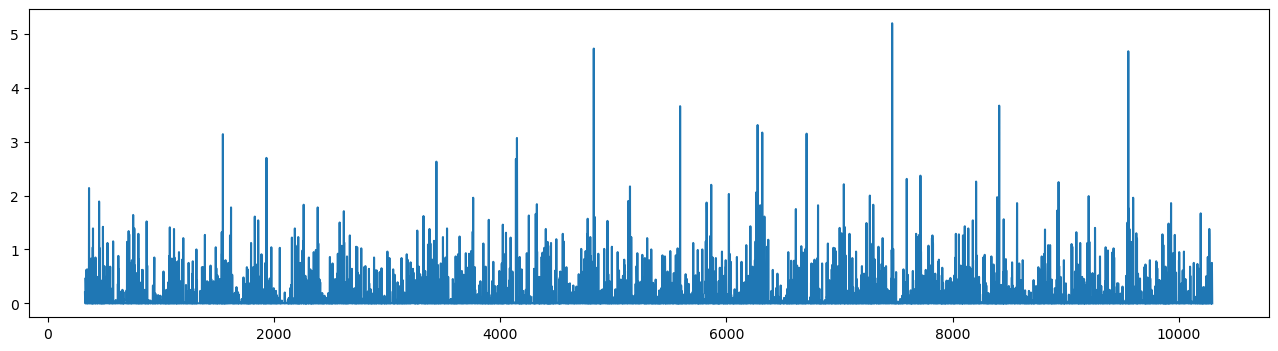

In [8]:
df['PRCP'].plot(figsize=(16,4))

<Axes: >

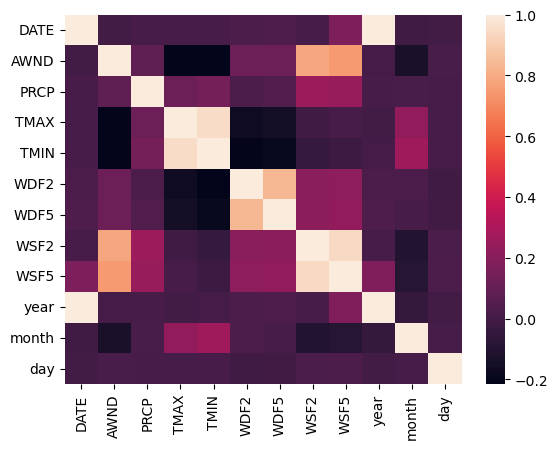

In [11]:
# Checking correlation heatmap
corr_df = df.corr()
sns.heatmap(corr_df)

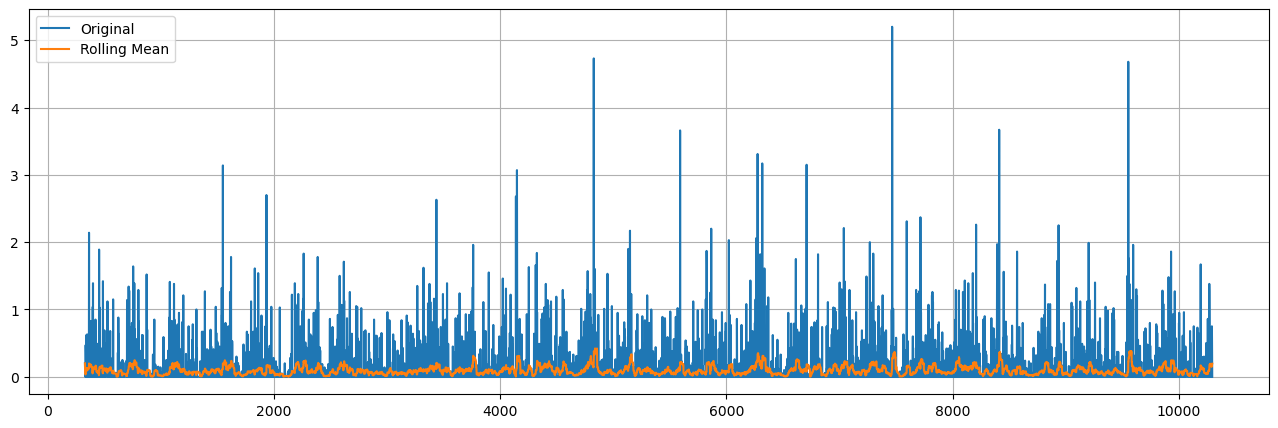

In [13]:
# Add rolling average of PRCP column
df['PRCP_rolling'] = df['PRCP'].rolling(window=30, min_periods=1).mean()

# Compare PRCP with its rolling average to check for stationarity
fig, ax = plt.subplots(figsize=(16,5), facecolor='w')
ax.plot(df['PRCP'], label='Original')
ax.plot(df['PRCP_rolling'], label='Rolling Mean')

ax.legend()
plt.grid()
plt.show();

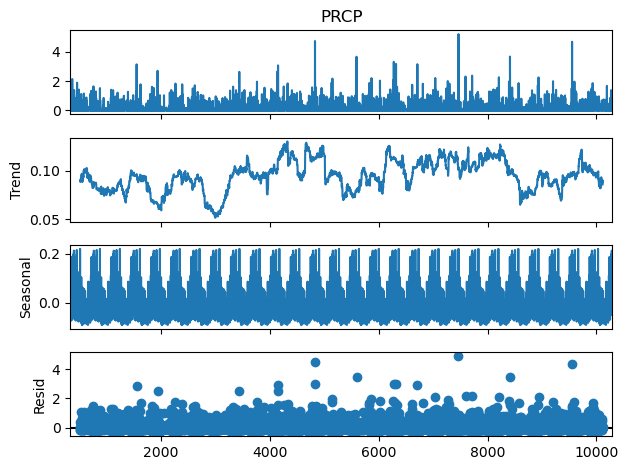

In [19]:
# Decomposing trend and seasonality
res = seasonal_decompose(df['PRCP'], period=365)
res.plot();

## Findings
* Based on the initial analysis of the data, there does not seem to be any strong correlation between any of the data points, except where it is expected (such as average wind direction being correlated with peak 5 minute winds and peak 2 second winds)
* When looked at as a time series, there does not appear to be any overall trend, but there is high seasonality. This is expected with annual weather cycles
* Time series analysis is likely the best option for a data set like this, however first we will explore some more basic regression models in case any patterns arise, or at the very least to use as a baseline

# Basic Regression Models

In [25]:
# Split training and testing data
X = df.drop(['DATE', 'PRCP'], axis=1)
y = df['PRCP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Linear regression models with polynomial degree 1-5

# Create empty lists of training and test mean squared errors
train_mses = []
test_mses = []

# For loop to iterate over each polynomial degree
for i in range(1,5):
    # Pipeline for linear regression
    pipe = Pipeline([
        ('polyfeatures', PolynomialFeatures(degree=i)),
        ('scaler', StandardScaler()),
        ('linreg', LinearRegression())
    ])
    # Fit the model on training data
    pipe.fit(X_train, y_train)
    # Make predictions for training and test data
    p1 = pipe.predict(X_train)
    p2 = pipe.predict(X_test)
    # Mean squared errors calculated for train and test sets
    train_mses.append(mean_squared_error(y_train, p1))
    test_mses.append(mean_squared_error(y_test, p2))

# Cross validation
# Create dataframe with training and test mean squared errors for each value of K (polynomial degree)
k_values = np.array(range(1,5))
MSEs_w_k = pd.DataFrame({"k": k_values, "Train MSE": train_mses, "Test MSE": test_mses})
MSEs_w_k

,k,Train MSE,Test MSE
0,1,0.065179,0.063747
1,2,0.059727,0.061139
2,3,0.052186,0.067491
3,4,0.038016,0.705982


In [29]:
# Instantiating several more basic regression models to compare performance
lin1 = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=1)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])


lin2 = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

ridge = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

lasso = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# Creating dictionary for model names to be displayed in DataFrame
model_dict = {lin1: "Linear Regression Degree 1",
              lin2: "Linear Regression Degree 2",
              ridge: "Ridge Regression",
              lasso: "Lasso Regression"}

In [31]:
# Creating a function to evaluate runtime, training accuracy, and test accuracy for a list of un-fitted models
def model_checker(models):
    """
    This function evaluates the training time, training MSE, and test MSE for a set of models.
    ---
    Args:
        models: Dictionary mapping model names to instantiated models
    Returns: None
    """
    # Empty lists to append after iterating through each model
    model_names = []
    train_times = []
    train_mses = []
    test_mses = []

    # Looping over each model from list
    for model in models:
        # Training model and calculating runtime
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()

        # Computing training and test accuracy
        train_mse = mean_squared_error(y_train, model.predict(X_train))
        test_mse = mean_squared_error(y_test, model.predict(X_test))

        # Adding information to lists
        model_names.append(model_dict[model])
        train_times.append(end_time - start_time)
        train_mses.append(train_mse)
        test_mses.append(test_mse)

    # Create data frame with each list as a column
    summary = pd.DataFrame({'Model': model_names,
                            'Train Time (s)': train_times,
                            'Train MSE': train_mses,
                            'Test MSE': test_mses})
    # Display data frame
    display(summary)

In [33]:
# Checking basic regression model performance
models = [lin1, lin2, ridge, lasso]

model_checker(models)

,Model,Train Time (s),Train MSE,Test MSE
0,Linear Regression Degree 1,0.018050,0.065179,0.063747
1,Linear Regression Degree 2,0.088973,0.059727,0.061139
2,Ridge Regression,0.056031,0.060032,0.060721
3,Lasso Regression,0.065978,0.077529,0.073681


In [35]:
# GridSearchCV for degree 2 linear regression
lin2_param_space = {'linreg__copy_X': [True,False], 
               'linreg__fit_intercept': [True,False], 
               'linreg__n_jobs': [1,5,10,15,None], 
               'linreg__positive': [True,False]}

lin2_grid_search = GridSearchCV(lin2, lin2_param_space, cv=5)
lin2_grid_search.fit(X_train, y_train)

lin2_best = lin2_grid_search.best_estimator_
lin2_best_test_mse = mean_squared_error(y_test, lin2_best.predict(X_test))

# Parameter which gives the best results
print(f"Best Hyperparameters: {lin2_grid_search.best_params_}")

# Accuracy of the model after using best parameters
print(f"Best MSE: {lin2_best_test_mse}")

Best Hyperparameters: {'linreg__copy_X': True, 'linreg__fit_intercept': True, 'linreg__n_jobs': 1, 'linreg__positive': False}
Best MSE: 0.06113910997674557


In [36]:
# GridSearchCV for ridge regression
ridge_param_space = {'ridge__alpha': 10**np.linspace(-4, 3, 10),
                     'ridge__fit_intercept': [True, False]}

ridge_grid_search = GridSearchCV(ridge, ridge_param_space, cv=5)
ridge_grid_search.fit(X_train, y_train)

ridge_best = ridge_grid_search.best_estimator_
ridge_best_test_mse = mean_squared_error(y_test, ridge_best.predict(X_test))

# Parameter which gives the best results
print(f"Best Hyperparameters: {ridge_grid_search.best_params_}")

# Accuracy of the model after using best parameters
print(f"Best MSE: {ridge_best_test_mse}")

Best Hyperparameters: {'ridge__alpha': 4.641588833612782, 'ridge__fit_intercept': True}
Best MSE: 0.060740747055850176


In [39]:
# Support Vector Regressor
svr = SVR(kernel='rbf').fit(X_train, y_train)

svr_mse = mean_squared_error(svr.predict(X_train), y_train)
print(f"Best MSE: {svr_mse}")

Best MSE: 0.07730112047128786


## Findings
* As expected, a linear regression model does not perform well, since precipitation amounts do not follow a linear pattern
* After hyperparameter tuning, the performance of a degree 2 polynomial regression and Ridge regression can be slightly improved, but not by very much
* Of all the models used, Support Vector Regressor using an RBF kernel function performed the worst out of all of the models, despite being one of the more sophisticated algorithms
* It may be possible to get better performance using ensemble techniques, such as a random forest regressor or gradient boost regressor

# Ensemble Models

In [44]:
# Random Forest Regressor
forest = RandomForestRegressor(n_estimators=25, oob_score=True)
forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=25, oob_score=True)

In [46]:
# Checking out of bag score and mean squared error
oob_score = forest.oob_score_
print(f'Random Forest Out-of-Bag Score: {oob_score}')

mse = mean_squared_error(y, forest.predict(X))
print(f'Random Forest Mean Squared Error: {mse}')

Random Forest Out-of-Bag Score: 0.06362555503902956
Random Forest Mean Squared Error: 0.026275680322093608


In [48]:
# Random Forest hyperparameter tuning with RandomizedSearchCV
forest_param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 3, 6],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

forest_grid_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=forest_param_grid, cv=5)
forest_grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3, 6],
                                        'n_estimators': [25, 50, 100, 200]})

In [49]:
forest_grid_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'bootstrap': True}

In [50]:
forest_best = forest_grid_search.best_estimator_
forest_best_preds = forest_best.predict(X)

forest_best_mse = mean_squared_error(y, forest_best_preds)
forest_best_mse

0.038456002263913845

In [55]:
# Creating model using best parameters from randomized search
optimum_forest = RandomForestRegressor(n_estimators=100, min_samples_split=3, min_samples_leaf=2, max_depth=10, bootstrap=True, oob_score=True)
optimum_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=3,
                      oob_score=True)

In [67]:
optimum_oob_score = forest.oob_score_
print(f'Random Forest Out-of-Bag Score: {optimum_oob_score}')

optimum_mse = mean_squared_error(y, optimum_forest.predict(X))
print(f'Random Forest Mean Squared Error: {optimum_mse}')

Random Forest Out-of-Bag Score: 0.06362555503902956
Random Forest Mean Squared Error: 0.03838747359498207


In [59]:
# Gradient Boosting Regressor
boost = GradientBoostingRegressor()
boost.fit(X_train, y_train)

GradientBoostingRegressor()

In [63]:
boost_train_mse =  mean_squared_error(y_train, boost.predict(X_train))
boost_test_mse = mean_squared_error(y_test, boost.predict(X_test))

print(f'Gradient Boosting Regressor train MSE: {boost_train_mse}')
print(f'Gradient Boosting Regressor test MSE: {boost_test_mse}')

Gradient Boosting Regressor train MSE: 0.046963864448139235
Gradient Boosting Regressor test MSE: 0.060917271667492064


## Findings
* A random forest regressor was able to significantly reduce the test error, however the out-of-bag score is very low at 6%. This indicates heavy overfitting to the data
* Using a Gradient Boosting Algorithm did not perform much better than simple linear regression algorithms

# Conclusion
* As expected, basic regression models such as linear regression and polynomial regression did not perform well, with a mean squared error of approximately 0.061 inches^2/day^2, or ~0.247 inches/day. This is a significant error, especially considering that it is more than half of the general threshold for requiring artificial irrigation, 0.41 inches per day
* Even more sophisticated regression models, such as Ridge regression and Support Vector Regressors had similar performance, even after hyperparameter tuning, indicating that these models are not appropriate for this problem.
* A random forest regressor was used as an ensemble technique to see if performance could be improved. While the mean squared error of the random forest model was significantly better than any of the other regression models, the out-of-bag score was very low at around 6%. This indicates that the model is overfitting the training data and is not very useful when seeing new data.
* Based on the above findings, as well as the fact that there appears to be some seasonality to the data when looking at it as a time series, time series analysis is likely the best option to answer this problem.
